In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# visualization
# get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import matplotlib.pyplot as plt

#make it so that we only show first 4 decimals for floats
# np.set_printoptions(precision=4,suppress=True)


/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read data into a DataFrame
def get_stockdata(symbol):
    df = None
    if symbol == 'SPY':
        # pd.read_csv reads csv file data
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv", index_col=['Date'], usecols=['Date','Close','Volume'])  
        df.columns = ['close','vol']
        return df
    if symbol == 'VIX':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv", index_col=['Date'], usecols=['Date','Close'])  
        df.columns = ['VIX_close']
        return df
    if symbol == 'SPX_PC':
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv", index_col=['DATE'], usecols=['DATE','P/C Ratio'])  
        df.columns = ['put_call_ratio']
        return df
    if symbol not in ['SPY','VIX']:
        df = pd.read_csv("./stockdata/{0}".format(symbol)+".csv", index_col=['Date'],usecols=['Date','Adj Close','Volume'])
        df.columns = ['close','vol']
        return df

In [3]:
# Read csv data in dataframe
stock_data = get_stockdata('BA') # Predict future price of this stock 'JPM'
print (stock_data.head())
# stock_data = stock_data.sort_index()
SPY_data = get_stockdata('SPY') # S&P 500 - gives direction of overall market
print (SPY_data.head())
# SPY_data = SPY_data.sort_index()
VIX_data = get_stockdata('VIX') # Volatility index of S&P 500
print (VIX_data.head())
# VIX_data = VIX_data.sort_index()
Put_Call_data = get_stockdata('SPX_PC') # put call ratio of S&P 500
print (Put_Call_data.tail())
# Put_Call_data = Put_Call_data.sort_index()

                close       vol
Date                           
2006-11-01  59.408970   3180100
2006-11-02  58.770798   4044600
2006-11-03  59.342175   2706700
2006-11-06  59.720631   3082600
2006-11-07  62.963406  11846400
                close       vol
Date                           
11/1/2006  136.860001  83005600
11/2/2006  136.779999  60693100
11/3/2006  136.539993  71346400
11/6/2006  138.080002  63303300
11/7/2006  138.610001  63318900
           VIX_close
Date                
11/1/2006      11.51
11/2/2006      11.42
11/3/2006      11.16
11/6/2006      11.16
11/7/2006      11.09
           put_call_ratio
DATE                     
6/25/2018            1.17
6/26/2018            1.19
6/27/2018            1.25
6/28/2018            1.31
6/29/2018            1.64


In [4]:
stock_data.index = stock_data.index.map(lambda x: pd.to_datetime(x))
SPY_data.index = SPY_data.index.map(lambda x: pd.to_datetime(x))
VIX_data.index = VIX_data.index.map(lambda x: pd.to_datetime(x))
Put_Call_data.index = Put_Call_data.index.map(lambda x: pd.to_datetime(x))

In [5]:
# Merge JPY, SPY, VIX and Put_call data
stock_data = stock_data.join(SPY_data, how="inner", rsuffix="_SPY")
stock_data = stock_data.join(VIX_data, how="inner")
stock_data = stock_data.join(Put_Call_data, how="inner")

stock_data = stock_data.sort_index(ascending=True)

In [6]:
print (stock_data.index)

DatetimeIndex(['2006-11-01', '2006-11-02', '2006-11-03', '2006-11-06',
               '2006-11-07', '2006-11-08', '2006-11-09', '2006-11-10',
               '2006-11-13', '2006-11-14',
               ...
               '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21',
               '2018-06-22', '2018-06-25', '2018-06-26', '2018-06-27',
               '2018-06-28', '2018-06-29'],
              dtype='datetime64[ns]', name='Date', length=2935, freq=None)


In [7]:
# Prediction of future stock price on n'th day
forecast_out = 5

In [8]:
# Target variable 'y' is the stock price after certain days = n days
stock_data["future_date"]=pd.datetime(1990,1,1) # Initialize
print(stock_data.tail(10))
stock_data["future_date"][:-forecast_out] = stock_data.index[forecast_out:]
print(stock_data.tail(10))
stock_data["observed_closing_price"]=-1 # Initialize
print(stock_data.tail(10))
stock_data["observed_closing_price"][:-forecast_out] = stock_data["close"][forecast_out:]
print(stock_data.tail(10))
#note: date of 1900-01-01 and future price of -1 signifies the lack of sufficient prod data

                 close      vol   close_SPY    vol_SPY  VIX_close  \
Date                                                                
2018-06-18  354.739990  3363200  276.559998   52917600      12.31   
2018-06-19  341.119995  6857300  275.500000   97531500      13.35   
2018-06-20  342.690002  4540000  275.970001   53785500      12.79   
2018-06-21  337.660004  4048300  274.239990   71061400      14.64   
2018-06-22  338.910004  3192000  274.739990   54898500      13.77   
2018-06-25  331.200012  5006200  271.000000  137854200      17.33   
2018-06-26  331.299988  3112400  271.600006   68547400      15.92   
2018-06-27  329.820007  4578900  269.350006  105110700      17.91   
2018-06-28  334.649994  3348000  270.890015   76650500      16.85   
2018-06-29  335.510010  3108500  271.279999   97524300      16.09   

            put_call_ratio future_date  
Date                                    
2018-06-18            1.58  1990-01-01  
2018-06-19            0.85  1990-01-01  
2018-06

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
stock_data[-forecast_out-1:].tail()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,observed_closing_price
Date,,,,,,,,
2018-06-25,331.200012,5006200,271.000000,137854200,17.33,1.17,1990-01-01,-1.0
2018-06-26,331.299988,3112400,271.600006,68547400,15.92,1.19,1990-01-01,-1.0
2018-06-27,329.820007,4578900,269.350006,105110700,17.91,1.25,1990-01-01,-1.0
2018-06-28,334.649994,3348000,270.890015,76650500,16.85,1.31,1990-01-01,-1.0
2018-06-29,335.510010,3108500,271.279999,97524300,16.09,1.64,1990-01-01,-1.0


In [10]:
stock_data["daily_return"]=0.000000001
stock_data["daily_return"][1:]=np.log(stock_data["close"][1:]/stock_data["close"][:-1].values)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
stock_data["daily_return"].tail()

Date
2018-06-25   -0.023012
2018-06-26    0.000302
2018-06-27   -0.004477
2018-06-28    0.014538
2018-06-29    0.002567
Name: daily_return, dtype: float64

In [12]:
# gets rolling mean for 5 day window. 
stock_data["rolling_mean"]=stock_data["close"].rolling(window=forecast_out).mean()
stock_data["rolling_sd"]=stock_data["close"].rolling(window=forecast_out).std()
stock_data["rolling_mean"].fillna(0,inplace=True)
stock_data["rolling_sd"].fillna(0,inplace=True)


In [13]:
stock_data.tail()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,observed_closing_price,daily_return,rolling_mean,rolling_sd
Date,,,,,,,,,,,
2018-06-25,331.200012,5006200,271.000000,137854200,17.33,1.17,1990-01-01,-1.0,-0.023012,338.316003,4.427605
2018-06-26,331.299988,3112400,271.600006,68547400,15.92,1.19,1990-01-01,-1.0,0.000302,336.352002,5.012243
2018-06-27,329.820007,4578900,269.350006,105110700,17.91,1.25,1990-01-01,-1.0,-0.004477,333.778003,4.179106
2018-06-28,334.649994,3348000,270.890015,76650500,16.85,1.31,1990-01-01,-1.0,0.014538,333.176001,3.665314
2018-06-29,335.510010,3108500,271.279999,97524300,16.09,1.64,1990-01-01,-1.0,0.002567,332.496002,2.449230


In [14]:
def get_bollinger_params(x):
    upper_band, lower_band = x["rolling_mean"] + 2*x["rolling_sd"], x["rolling_mean"] - 2*x["rolling_sd"]
    return upper_band, lower_band

In [15]:
stock_data["bollinger_band"]=stock_data[["rolling_mean","rolling_sd"]].apply(get_bollinger_params,axis=1)
stock_data["upper_bollinger_band"]=stock_data["bollinger_band"].apply(lambda x: x[0])
stock_data["lower_bollinger_band"]=stock_data["bollinger_band"].apply(lambda x: x[1])
stock_data = stock_data.drop("bollinger_band", axis = 1)

In [16]:
stock_data.fillna(method="bfill",inplace=True)

In [17]:
stock_data.head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,future_date,observed_closing_price,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band
Date,,,,,,,,,,,,,
2006-11-01,59.408970,3180100,136.860001,83005600,11.51,1.25,2006-11-08,63.633625,1.000000e-09,0.000000,0.000000,0.000000,0.000000
2006-11-02,58.770798,4044600,136.779999,60693100,11.42,1.12,2006-11-09,63.380428,-1.080013e-02,0.000000,0.000000,0.000000,0.000000
2006-11-03,59.342175,2706700,136.539993,71346400,11.16,1.26,2006-11-10,63.760239,9.675168e-03,0.000000,0.000000,0.000000,0.000000
2006-11-06,59.720631,3082600,138.080002,63303300,11.16,1.26,2006-11-13,63.812355,6.357271e-03,0.000000,0.000000,0.000000,0.000000
2006-11-07,62.963406,11846400,138.610001,63318900,11.09,1.04,2006-11-14,63.849575,5.287616e-02,60.041196,1.669156,63.379508,56.702884


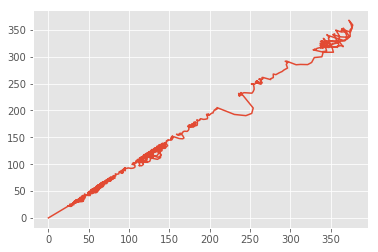

In [18]:
plt. plot(stock_data["upper_bollinger_band"],stock_data["lower_bollinger_band"])

In [19]:
stock_data = stock_data[stock_data.columns.tolist()[0:6]+stock_data.columns.tolist()[8:]+stock_data.columns.tolist()[6:8]]
stock_data.columns.tolist()

['close',
 'vol',
 'close_SPY',
 'vol_SPY',
 'VIX_close',
 'put_call_ratio',
 'daily_return',
 'rolling_mean',
 'rolling_sd',
 'upper_bollinger_band',
 'lower_bollinger_band',
 'future_date',
 'observed_closing_price']

In [20]:
stock_data[-10:].head(10)


,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band,future_date,observed_closing_price
Date,,,,,,,,,,,,,
2018-06-18,354.739990,3363200,276.559998,52917600,12.31,1.58,-0.008813,361.902002,6.073247,374.048496,349.755507,2018-06-25,331.200012
2018-06-19,341.119995,6857300,275.500000,97531500,13.35,0.85,-0.039151,356.002002,9.074356,374.150713,337.853290,2018-06-26,331.299988
2018-06-20,342.690002,4540000,275.970001,53785500,12.79,1.38,0.004592,351.770001,9.426621,370.623243,332.916759,2018-06-27,329.820007
2018-06-21,337.660004,4048300,274.239990,71061400,14.64,1.30,-0.014787,346.817999,8.923318,364.664635,328.971364,2018-06-28,334.649994
2018-06-22,338.910004,3192000,274.739990,54898500,13.77,1.25,0.003695,343.023999,6.831885,356.687770,329.360228,2018-06-29,335.510010
2018-06-25,331.200012,5006200,271.000000,137854200,17.33,1.17,-0.023012,338.316003,4.427605,347.171213,329.460794,1990-01-01,-1.000000
2018-06-26,331.299988,3112400,271.600006,68547400,15.92,1.19,0.000302,336.352002,5.012243,346.376489,326.327515,1990-01-01,-1.000000
2018-06-27,329.820007,4578900,269.350006,105110700,17.91,1.25,-0.004477,333.778003,4.179106,342.136214,325.419792,1990-01-01,-1.000000
2018-06-28,334.649994,3348000,270.890015,76650500,16.85,1.31,0.014538,333.176001,3.665314,340.506628,325.845374,1990-01-01,-1.000000


In [21]:
scaling_features = stock_data.columns.tolist()[:-2]
print (scaling_features)

['close', 'vol', 'close_SPY', 'vol_SPY', 'VIX_close', 'put_call_ratio', 'daily_return', 'rolling_mean', 'rolling_sd', 'upper_bollinger_band', 'lower_bollinger_band']


In [22]:
scaler = StandardScaler()
X = stock_data[scaling_features]
X_lately = X[-forecast_out:]
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=["scaled_"+i for i in scaling_features])

In [23]:
stock_data.iloc[:23]
stock_data.head()

,close,vol,close_SPY,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band,future_date,observed_closing_price
Date,,,,,,,,,,,,,
2006-11-01,59.408970,3180100,136.860001,83005600,11.51,1.25,1.000000e-09,0.000000,0.000000,0.000000,0.000000,2006-11-08,63.633625
2006-11-02,58.770798,4044600,136.779999,60693100,11.42,1.12,-1.080013e-02,0.000000,0.000000,0.000000,0.000000,2006-11-09,63.380428
2006-11-03,59.342175,2706700,136.539993,71346400,11.16,1.26,9.675168e-03,0.000000,0.000000,0.000000,0.000000,2006-11-10,63.760239
2006-11-06,59.720631,3082600,138.080002,63303300,11.16,1.26,6.357271e-03,0.000000,0.000000,0.000000,0.000000,2006-11-13,63.812355
2006-11-07,62.963406,11846400,138.610001,63318900,11.09,1.04,5.287616e-02,60.041196,1.669156,63.379508,56.702884,2006-11-14,63.849575


In [24]:
# Vertical merge the scaled data with original
stock_data = stock_data.reset_index()   #To retain the index , which corresponds to Date column
stock_data=pd.concat([X_scaled,stock_data],axis=1)

In [25]:
stock_data.index

RangeIndex(start=0, stop=2935, step=1)

In [26]:
# set index to zero beacuse concat brought in two dates and number @ index[0] 
stock_data = stock_data.set_index('Date')

In [27]:
print (stock_data.index.max(), stock_data.index.min())

2018-06-29 00:00:00 2006-11-01 00:00:00


In [28]:
# print(classification_report(y_test, y_pred))
# making copy of stock_data & getting date out of middle of table with days to look forwad metric.
# saving data in master_stock_data. at this point will not modify stock_data.
master_stock_data = stock_data.copy()
columns_replaced_with_underscores= [np.str.replace(i," ","_") for i in master_stock_data.columns.tolist()]
master_stock_data = master_stock_data[columns_replaced_with_underscores]
master_stock_data = master_stock_data[forecast_out - 1:-forecast_out]

In [29]:
stock_data[16:].head()

,scaled_close,scaled_vol,scaled_close_SPY,scaled_vol_SPY,scaled_VIX_close,scaled_put_call_ratio,scaled_daily_return,scaled_rolling_mean,scaled_rolling_sd,scaled_upper_bollinger_band,...,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band,future_date,observed_closing_price
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-24,-0.490200,-1.410005,-0.483828,-1.261924,-0.927937,2.877193,-0.240360,-0.486115,-0.571099,-0.495257,...,30998000,10.73,2.10,-0.003669,66.963867,0.558165,68.080197,65.847537,2006-12-01,66.686852
2006-11-27,-0.515510,0.401449,-0.522278,-0.737790,-0.763239,3.228811,-1.562703,-0.490662,-0.216825,-0.486583,...,84545100,12.30,2.21,-0.027099,66.643643,1.031460,68.706564,64.580722,2006-12-04,66.709190
2006-11-28,-0.509499,-0.074484,-0.510325,-0.521393,-0.834573,1.055171,0.333721,-0.493158,-0.122398,-0.485522,...,106652900,11.62,1.53,0.006503,66.467894,1.157610,68.783114,64.152674,2006-12-05,67.565590
2006-11-29,-0.499480,-0.261398,-0.481438,-0.684054,-0.917447,-0.383268,0.573133,-0.497831,-0.339882,-0.498128,...,90034900,10.83,1.08,0.010745,66.138747,0.867061,67.872868,64.404626,2006-12-06,67.640053
2006-11-30,-0.503277,-0.344883,-0.480243,-0.743181,-0.909054,-0.702921,-0.262323,-0.501152,-0.478282,-0.506488,...,83994300,10.91,0.98,-0.004058,65.904916,0.682165,67.269246,64.540587,2006-12-07,67.029419


In [30]:
master_stock_data.head()

,scaled_close,scaled_vol,scaled_close_SPY,scaled_vol_SPY,scaled_VIX_close,scaled_put_call_ratio,scaled_daily_return,scaled_rolling_mean,scaled_rolling_sd,scaled_upper_bollinger_band,...,vol_SPY,VIX_close,put_call_ratio,daily_return,rolling_mean,rolling_sd,upper_bollinger_band,lower_bollinger_band,future_date,observed_closing_price
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-07,-0.545248,2.389989,-0.518493,-0.945558,-0.890172,-0.511129,2.950895,-0.584413,0.260507,-0.560358,...,63318900,11.09,1.04,0.052876,60.041196,1.669156,63.379508,56.702884,2006-11-14,63.849575
2006-11-08,-0.535757,1.192848,-0.512516,-0.708692,-0.925839,-0.670956,0.564286,-0.572415,0.688226,-0.532829,...,87517800,10.75,0.99,0.010588,60.886127,2.240570,65.367267,56.404987,2006-11-15,64.847466
2006-11-09,-0.539343,0.353380,-0.527059,-0.626486,-0.898564,0.703552,-0.258300,-0.559325,0.580232,-0.524057,...,95916300,11.01,1.42,-0.003987,61.808053,2.096294,66.000642,57.615464,2006-11-16,66.061310
2006-11-10,-0.533964,0.120650,-0.525864,-1.085798,-0.921643,-0.063615,0.303905,-0.546778,0.275003,-0.523114,...,48991500,10.79,1.18,0.005975,62.691666,1.688522,66.068709,59.314623,2006-11-17,66.664520
2006-11-13,-0.533226,-0.642909,-0.519090,-0.983935,-0.914299,0.511761,0.012822,-0.535158,-0.728289,-0.548907,...,59398200,10.86,1.36,0.000817,63.510011,0.348165,64.206340,62.813681,2006-11-20,66.366631


In [31]:
# Split entire data in test data and prod data
never_seen_window = 90

# Strip test_train data and prod data according to "forecast_out"
never_seen_data = master_stock_data[-never_seen_window:]
test_train_data = master_stock_data[:-never_seen_window]

In [32]:
never_seen_data.shape
test_train_data.shape

(2836, 24)

In [33]:
X_scaled_features = [i for i in test_train_data.columns.tolist() if 'scaled' in i]
print (X_scaled_features)

['scaled_close', 'scaled_vol', 'scaled_close_SPY', 'scaled_vol_SPY', 'scaled_VIX_close', 'scaled_put_call_ratio', 'scaled_daily_return', 'scaled_rolling_mean', 'scaled_rolling_sd', 'scaled_upper_bollinger_band', 'scaled_lower_bollinger_band']


In [34]:
X = test_train_data[X_scaled_features]
y = test_train_data.observed_closing_price

prod_X = never_seen_data[X_scaled_features]

In [35]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=234)
print ("training data size:",X_train.shape)
print ("testing data size:",X_test.shape)
#train on training set
mult_linreg = LinearRegression()
mult_linreg.fit(X_train, y_train)

#generate predictions on test set and evaluate
y_mult_pred_test = mult_linreg.predict(X_test)
print ("Prediction set RMSE:",np.sqrt(np.abs(metrics.mean_squared_error(y_test, y_mult_pred_test))))

training data size: (2552, 11)
testing data size: (284, 11)
Prediction set RMSE: 3.0845591456092105


In [36]:
never_seen_data_predictions = mult_linreg.predict(prod_X)
print ("never_seen_data_predictions - RMSE:",np.sqrt(np.abs(mean_squared_error(never_seen_data.observed_closing_price,never_seen_data_predictions))))

# new column predictor to prod data (with least RMSE)
never_seen_data["predicted_price"]=never_seen_data_predictions

never_seen_data_predictions - RMSE: 14.311794096850198


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [37]:
# Plotting graph with x="future_date", and y = ["observed_closing_price","prediction_close"]
df = never_seen_data[['future_date','observed_closing_price','predicted_price']]
df = df.reset_index()
df.head()

,Date,future_date,observed_closing_price,predicted_price
0,2018-02-14,2018-02-22,354.153320,349.472912
1,2018-02-15,2018-02-23,354.889648,360.605965
2,2018-02-16,2018-02-26,361.675812,359.932465
3,2018-02-20,2018-02-27,362.830048,358.819962
4,2018-02-21,2018-02-28,360.412079,358.371871


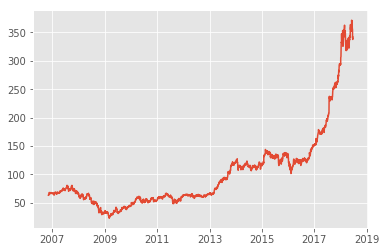

In [38]:
plt.plot(master_stock_data['close'])

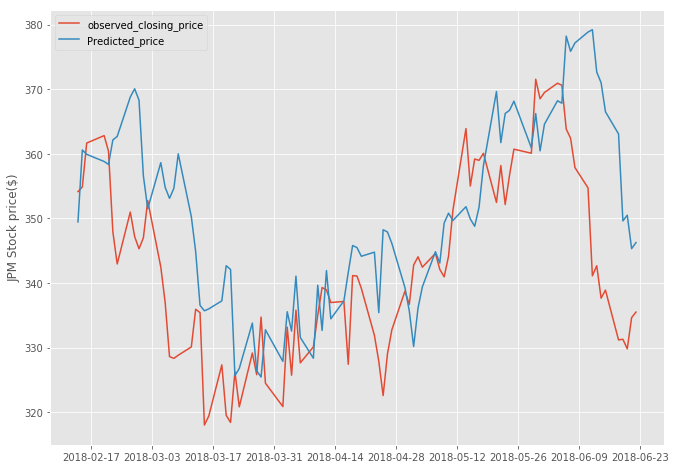

In [56]:
fig, ax = plt.subplots(figsize=(11,8))
ax.plot(never_seen_data.index, never_seen_data.observed_closing_price, label='observed_closing_price')
ax.plot(never_seen_data.index, never_seen_data.predicted_price, label='Predicted_price')
ax.set_ylabel("JPM Stock price($)")
ax.legend()
# fig.savefig('lin_reg_BA.png', bbox_inches='tight')

In [40]:
mult_feature_cols = prod_X.columns.tolist()
feature_importance= pd.DataFrame(list(zip(mult_feature_cols, mult_linreg.coef_)), columns=["Features","Coefficient"])

In [41]:
feature_importance.sort_values("Coefficient",inplace=True, ascending=False)

In [42]:
feature_importance


,Features,Coefficient
0,scaled_close,64.281599
10,scaled_lower_bollinger_band,3.130195
7,scaled_rolling_mean,3.047895
9,scaled_upper_bollinger_band,2.967152
4,scaled_VIX_close,0.102171
1,scaled_vol,0.067281
6,scaled_daily_return,0.057856
5,scaled_put_call_ratio,-0.037658
3,scaled_vol_SPY,-0.097078
8,scaled_rolling_sd,-0.150313


In [43]:
rf = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=1)
rf.fit(X_train, y_train)
y_prediction_price_rf = rf.predict(X_test)
# root mean square error 
print("Random Forest RMSE on Test Data:",np.sqrt(mean_squared_error(y_test, y_prediction_price_rf)))

Random Forest RMSE on Test Data: 2.563253241648068


In [44]:
never_seen_data_predection_rf = rf.predict(prod_X)
print("Random Forest RMSE on Production Data:",np.sqrt(mean_squared_error(never_seen_data.observed_closing_price, never_seen_data_predection_rf)))

# Add new column predictor to never_seen_data (with least RMSE)
never_seen_data["predicted_price_rf"]=never_seen_data_predection_rf

Random Forest RMSE on Production Data: 16.266082242265792


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [45]:

# Plotting graph with x="future_date", and y = ["observed_closing_price","prediction_close"]
df = never_seen_data[['future_date','observed_closing_price','predicted_price','predicted_price_rf']]
df = df.reset_index()
df.head()

,Date,future_date,observed_closing_price,predicted_price,predicted_price_rf
0,2018-02-14,2018-02-22,354.153320,349.472912,342.922357
1,2018-02-15,2018-02-23,354.889648,360.605965,340.756666
2,2018-02-16,2018-02-26,361.675812,359.932465,340.417993
3,2018-02-20,2018-02-27,362.830048,358.819962,338.725784
4,2018-02-21,2018-02-28,360.412079,358.371871,338.630645


In [46]:
df = df.set_index('future_date')
df.head()

,Date,observed_closing_price,predicted_price,predicted_price_rf
future_date,,,,
2018-02-22,2018-02-14,354.153320,349.472912,342.922357
2018-02-23,2018-02-15,354.889648,360.605965,340.756666
2018-02-26,2018-02-16,361.675812,359.932465,340.417993
2018-02-27,2018-02-20,362.830048,358.819962,338.725784
2018-02-28,2018-02-21,360.412079,358.371871,338.630645


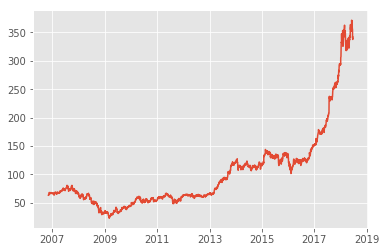

In [47]:
# Plot of entire data
plt.plot(master_stock_data['close'])

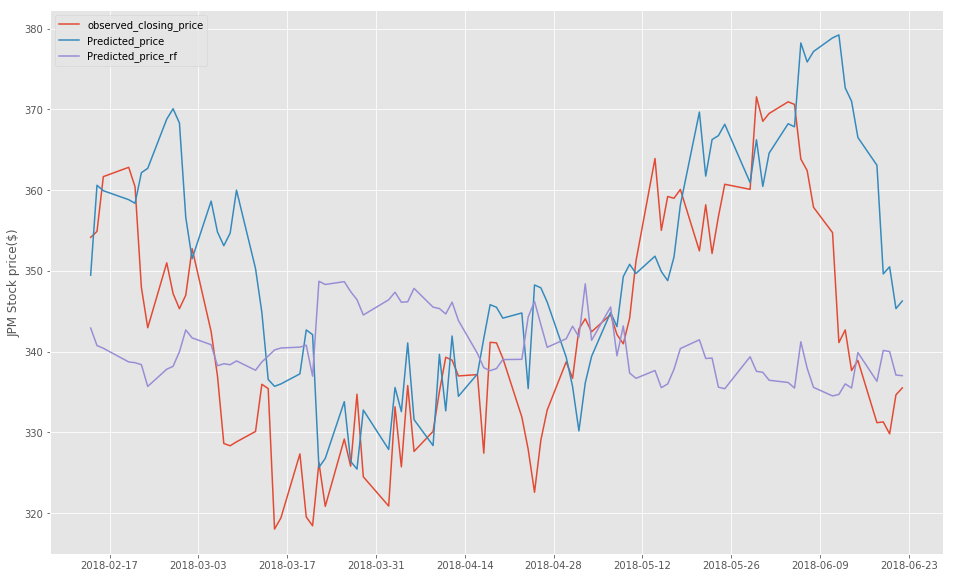

In [57]:
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(never_seen_data.index, never_seen_data.observed_closing_price, label='observed_closing_price')
ax.plot(never_seen_data.index, never_seen_data.predicted_price, label='Predicted_price')
ax.plot(never_seen_data.index, never_seen_data.predicted_price_rf, label = 'Predicted_price_rf')
ax.set_ylabel("JPM Stock price($)")
ax.legend()
fig.savefig('random_forest_BA.png', bbox_inches='tight')

In [49]:

mult_feature_cols_rf = prod_X.columns.tolist()
feature_importance_rf= pd.DataFrame(list(zip(mult_feature_cols_rf, rf.feature_importances_)), columns=["Features","Feature Importance"])

In [50]:
feature_importance_rf.sort_values("Feature Importance",inplace=True, ascending=False)

In [51]:
feature_importance_rf

,Features,Feature Importance
9,scaled_upper_bollinger_band,0.502499
7,scaled_rolling_mean,0.198729
0,scaled_close,0.195900
10,scaled_lower_bollinger_band,0.057678
2,scaled_close_SPY,0.043832
4,scaled_VIX_close,0.000348
8,scaled_rolling_sd,0.000246
1,scaled_vol,0.000226
3,scaled_vol_SPY,0.000201
5,scaled_put_call_ratio,0.000184


In [52]:
forecast_set = rf.predict(X_lately)

In [53]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [54]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] +[i]
print(df.tail(5))

                    Date  observed_closing_price  predicted_price  \
future_date                                                         
2018-06-29 20:00:00  NaT                     NaN              NaN   
2018-06-30 20:00:00  NaT                     NaN              NaN   
2018-07-01 20:00:00  NaT                     NaN              NaN   
2018-07-02 20:00:00  NaT                     NaN              NaN   
2018-07-03 20:00:00  NaT                     NaN              NaN   

                     predicted_price_rf    Forecast  
future_date                                          
2018-06-29 20:00:00                 NaN  341.823756  
2018-06-30 20:00:00                 NaN  341.568250  
2018-07-01 20:00:00                 NaN  341.834067  
2018-07-02 20:00:00                 NaN  341.853456  
2018-07-03 20:00:00                 NaN  341.146323  


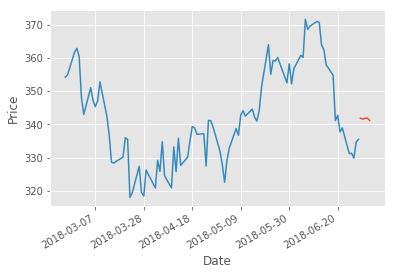

In [55]:
df['Forecast'].plot()
df['observed_closing_price'].plot()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()